In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn import metrics
%matplotlib inline
import datetime

In [2]:
#path = "../../../Google Drive/Data_science/NYU/Machine Learning/ML Project (Collisions)/" #Joe
path = "../../../../Google Drive/ML Project (Collisions)/" # Joyce
# path = "" # Lucas

## Using H2O without 1 hot encoding

In [3]:
with open(path+"collisions_no1hot.pkl", 'rb') as infile:
    df_no1hot = pickle.load(infile)

In [4]:
df_no1hot['year'] = pd.to_datetime(df_no1hot['date_time']).dt.year

In [5]:
df_no1hot = df_no1hot.sort_values('date_time')

In [6]:
view_date = pd.to_datetime(df_no1hot['date_time'])

train_indices = (0, np.sum(view_date < datetime.date(2015,9,12))-1)
val_indices = (train_indices[1]+1,\
               train_indices[1] + \
               np.sum((view_date >= datetime.date(2015,9,12)) & (view_date < datetime.date(2016,7,31))))
test_indices = (val_indices[1]+1,\
               val_indices[1] + np.sum(view_date >= datetime.date(2016,7,31)))

In [7]:
df_no1hot.to_csv(path+"no1hot.csv")

In [8]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [9]:
h2o.init(ip="127.0.0.1",max_mem_size_GB = 4)

Checking whether there is an H2O instance running at http://127.0.0.1:54321. connected.


H2O cluster uptime:,7 days 17 hours 35 mins
H2O cluster version:,3.10.4.3
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_joycewu_aayuou
H2O cluster total nodes:,1
H2O cluster free memory:,3.043 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [10]:
h2o.connect()

Connecting to H2O server at http://localhost:54321... successful.


H2O cluster uptime:,7 days 17 hours 35 mins
H2O cluster version:,3.10.4.3
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_joycewu_aayuou
H2O cluster total nodes:,1
H2O cluster free memory:,3.043 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


<H2OConnection to http://localhost:54321, session _sid_9e11>

In [11]:
dataFrame = h2o.upload_file(path=path+"no1hot.csv", destination_frame="no1hot")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
dataFrame = dataFrame.drop(['vehicle_type_code_1_nan',
 'vehicle_type_code_2_nan',
 'vehicle_type_code_3_nan',
 'vehicle_type_code_4_nan',
 'vehicle_type_code_5_nan',
 'borough_nan', 'injured', 'killed', 'C1'])

In [13]:
train_df = dataFrame[train_indices[0]:train_indices[1], :]
val_df = dataFrame[val_indices[0]:val_indices[1], :]
test_df = dataFrame[test_indices[0]:test_indices[1], :]

In [14]:
def score_confusion(confusion):
    sensitivity = confusion[1][1]/float(np.sum(confusion[1]))
    specificity = confusion[0][0]/float(np.sum(confusion[0]))
    return sensitivity, specificity

In [138]:
grid_search = []

In [ ]:
n_trees = [50, 100, 200]
max_depth = [10, 20, 50, 100]
min_rows = [None, 10, 50, 100]

for i in itertools.product(n_trees,max_depth,min_rows):
    
    if i not in [i[0] for i in grid_search]:
    
        rf = H2ORandomForestEstimator(
        model_id = "rf",
        ntrees=i[0],
        max_depth = i[1],
        min_rows = i[2],
        stopping_rounds=2)

        rf.train(train_df.drop('injured_or_killed').columns, 'injured_or_killed',\
                 training_frame=train_df, validation_frame=val_df)

        results = [i,\
                    rf.auc(train=True),\
                    rf.auc(valid=True),\
                    score_confusion(rf.confusion_matrix(train=True).to_list()),\
                    score_confusion(rf.confusion_matrix(valid=True).to_list())]
        print ("%s finished!" % (str(i)))
        print ("Train AUC: %s, Valid AUC: %s, Train S&S: %s, Valid S&S: %s" % (results[1], results[2], results[3], results[4]))
        
        grid_search.append(results)   
        

In [ ]:
results = pd.DataFrame(grid_search)
results.to_csv("tmp.csv")

## Sklearn with 1 hot


In [19]:
with open(path+"collisions_1hot.pkl", 'rb') as infile:
    df = pickle.load(infile)

In [20]:
df = df.drop(['injured', 'killed'], axis=1)

In [21]:
X_train = df.drop(['injured_or_killed'], axis=1).iloc[train_indices[0]:train_indices[1]]
y_train = df['injured_or_killed'].iloc[train_indices[0]:train_indices[1]]
X_val = df.drop(['injured_or_killed'], axis=1).iloc[val_indices[0]:val_indices[1]]
y_val = df['injured_or_killed'][val_indices[0]:val_indices[1]]
X_test = df.drop(['injured_or_killed'], axis=1).iloc[test_indices[0]:test_indices[1]]
y_test = df['injured_or_killed'][test_indices[0]:test_indices[1]]

In [129]:
sk_grid_search = []

In [130]:
n_trees = [50, 100, 200]
max_depth = [10, 20, 50, 100]
min_rows = [1, 10, 50, 100]

for i in itertools.product(n_trees,max_depth,min_rows):
    
    rf = RandomForestClassifier(n_estimators=i[0], max_depth=i[1], min_samples_leaf=i[2])
    rf.fit(X_train, y_train)
    
    #Train results
    t_predictions = rf.predict(X_train)
    t_predictions_prob = [i[1] for i in rf.predict_proba(X_train)]
    t_auc = metrics.roc_auc_score(y_train, t_predictions_prob)
    t_sens = y_train.astype(int).dot(t_predictions.astype(int))/np.sum(y_train)
    t_spec = (y_train == 0).astype(int).dot((t_predictions==0).astype(int))/np.sum((y_train == 0))
    
    #Val results
    v_predictions = rf.predict(X_val)
    v_predictions_prob = [i[1] for i in rf.predict_proba(X_val)]
    v_auc = metrics.roc_auc_score(y_val, v_predictions_prob)
    v_sens = y_val.astype(int).dot(v_predictions.astype(int))/np.sum(y_val)
    v_spec = (y_val == 0).astype(int).dot((v_predictions==0).astype(int))/np.sum((y_val == 0))
    
    results = [i,\
                t_auc,\
                v_auc,\
                (t_sens, t_spec),\
                (v_sens, v_spec)]
    
    
    print ("%s finished!" % (str(i)))
    print ("Train AUC: %s, Valid AUC: %s, Train S&S: %s, Valid S&S: %s" %\
           (results[1], results[2], results[3], results[4]))
    
    sk_grid_search.append(results)

(50, 10, 1) finished!
Train AUC: 0.780920179153, Valid AUC: 0.797071573862, Train S&S: (0.14445252290242838, 0.99124363012244321), Valid S&S: (0.26375911941635738, 0.97897258659963871)
(50, 10, 10) finished!
Train AUC: 0.777092520121, Valid AUC: 0.795031194447, Train S&S: (0.12142891764819931, 0.99255299384245166), Valid S&S: (0.24254447715346217, 0.98099128112481349)
(50, 10, 50) finished!
Train AUC: 0.77606412147, Valid AUC: 0.795473997621, Train S&S: (0.097096602200571952, 0.99267464080968226), Valid S&S: (0.23009727377447844, 0.97933390935511744)
(50, 10, 100) finished!
Train AUC: 0.775082370918, Valid AUC: 0.79681601551, Train S&S: (0.11057147011778391, 0.98854306744992571), Valid S&S: (0.26763087162421606, 0.97058361479852329)
(50, 20, 1) finished!
Train AUC: 0.88977313977, Valid AUC: 0.800644453987, Train S&S: (0.37694731229702877, 0.99127459480501101), Valid S&S: (0.38739920645078713, 0.96313722409865687)
(50, 20, 10) finished!
Train AUC: 0.843372236973, Valid AUC: 0.8038711314

In [132]:
results = pd.DataFrame(sk_grid_search)
results.to_csv("tmp.csv")

In [17]:
rf = H2ORandomForestEstimator(
model_id = "rf",
ntrees=200,
max_depth = 50,
min_rows = 50,
stopping_rounds=2)

rf.train(train_df.drop('injured_or_killed').columns, 'injured_or_killed',\
         training_frame=train_df, validation_frame=val_df)

drf Model Build progress: |███████████████████████████████████████████████| 100%


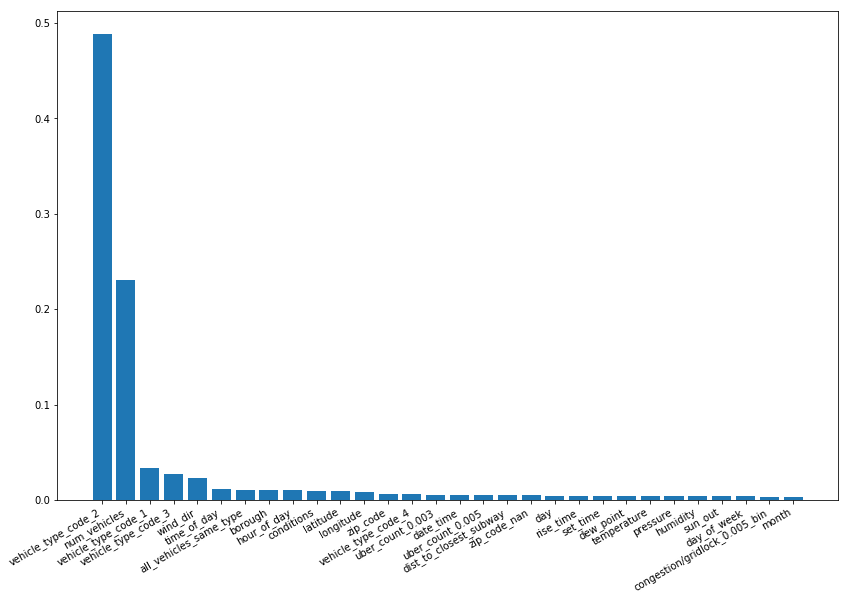

In [18]:
fig = plt.figure(figsize=(14, 10))

num_features = 30

y_pos = np.arange(num_features)

plt.bar(y_pos, rf.varimp(True)['percentage'][:num_features])
plt.xticks(y_pos, rf.varimp(True)['variable'][:num_features])
fig.autofmt_xdate()

In [22]:
rf = RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_leaf=50)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

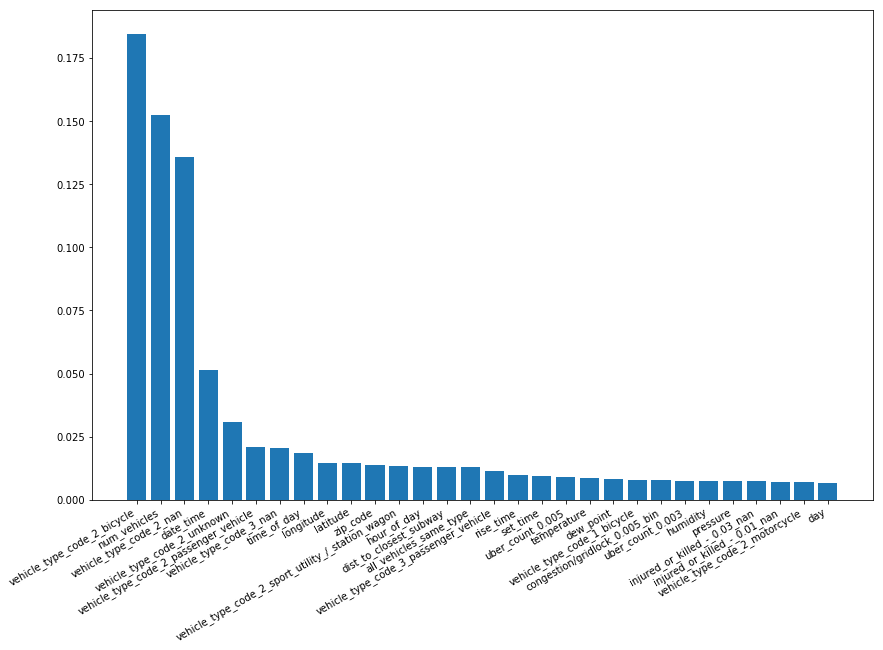

In [23]:
fig = plt.figure(figsize=(14, 10))

num_features = 30

y_pos = np.arange(num_features)
importances = np.vstack((rf.feature_importances_, X_train.columns.values)).T
topX = importances[importances[:,0].argsort()][::-1][:num_features]

plt.bar(y_pos, topX[:, 0])
plt.xticks(y_pos, topX[:, 1])
fig.autofmt_xdate()